In [24]:

from macd_functions import *    # stock functions , not used for MFs


from mftool import Mftool
mf = Mftool()


### Part 1 is for General MF analysis. 
- It can be for all MFs or Portfolio MFs read from a file
- This doesnt have amount invested info
- Funds are catagorised like below:
    - small, mid, large, hybrid
    - flexi (multi, thematic ...)
    - hedge (multi asset, debt, overseas, gold, ... (having low or negative corralation with market))


### Part 2 is for studying portfolio with Amount info added

In [21]:


### To get specific MF codes for portfolio funds, refer 'mf_ga_amfi.csv' and follow below steps


### Visit --> mf._const['get_quote_url'] --> https://www.amfiindia.com/spages/NAVAll.txt

## OR
## == to get via coding and filtering, 
# mf.get_scheme_codes()      
# get_available_schemes('canara')
# mf.get_scheme_historical_nav(120828,as_Dataframe=True)



## Part 1 -- MF Analysis

In [6]:
period = '5y'    ## period for MF analysis .. longer the better ... '1y', '3y'


## Reference for Risk Free return --> # kotak liquid fund
risk_free_mf = '0P0000XV6E.BO'   
risk_free_hist = yf.Ticker(risk_free_mf).history(period=period)
risk_free_hist['Week'] = risk_free_hist.index.strftime('%Y-%U')
risk_free_hist['Month'] = risk_free_hist.index.strftime('%Y-%m')
risk_free_hist['DATE'] = risk_free_hist.index.strftime('%Y-%m-%d')


## Reference for Market Benchmark return --> # Nifty50
market = '^NSEI'
market_hist = yf.Ticker(market).history(period=period)
market_hist['Week'] = market_hist.index.strftime('%Y-%U')
market_hist['Month'] = market_hist.index.strftime('%Y-%m')
market_hist['DATE'] = market_hist.index.strftime('%Y-%m-%d')


## Merging Risk free and Market returns datewise; --> to be used for MF ratio calculation
riskfree_market_df = pd.merge(risk_free_hist[['DATE', 'Close']], market_hist[['DATE', 'Close']],
                              suffixes=('_risk', '_market'),
                              on='DATE', how='inner')



def get_ratios(hist_df):
    '''
    hist_df: daily returns of a stock/MF
    '''
    hist_df['Month'] = hist_df.index.strftime('%Y-%m')
    hist_df['Week'] = hist_df.index.strftime('%Y-%U')
    hist_df['DATE'] = hist_df.index.strftime('%Y-%m-%d')

    hist_riskfree_market_df = pd.merge(riskfree_market_df, hist_df[['DATE', 'Week', 'Close']], on='DATE', how='inner')

    ## Daily Returns in %
    returns_df = hist_riskfree_market_df.groupby('DATE')[['Close_risk','Close_market','Close']].mean().pct_change().dropna()   # Week, DATE
    returns_df.rename(columns={'Close_risk':'risk_free_return', 'Close_market':'market_return', 'Close':'weekly_return'}, inplace=True)

    
    ## ==== RATIOS ====
    # beta -- Covariance with Market/variance (self-covariance) of market
    covariance = np.cov(returns_df['weekly_return'], returns_df['market_return'])
    beta = covariance[0,1] / covariance[1,1]   


    # Alpha -- Return beyond market return
    expected_return = returns_df['risk_free_return'] + beta * (returns_df['market_return'] - returns_df['risk_free_return'])
    alpha = returns_df['weekly_return'] - expected_return
    
    
    # Sharpe
    excess_return = returns_df['weekly_return'] - returns_df['risk_free_return']
    num_period = returns_df.shape[0]
    # -- to be averaged on yearly basis. 52 if weekly and 252 (working days) if daily returns
    # -- scale factor for yearly ratio -- np.sqrt(252) or np.sqrt(52) 
    #       --> Stats stuff: Annual number is directly proportional to mean and variance (sqrt for std)
    sharpe_ratio = np.sqrt(252) * excess_return.mean() / excess_return.std()
    

    # Information Ratio -- Return over benchmark
    excess_return = returns_df['weekly_return'] - returns_df['market_return']
    info_ratio = np.sqrt(252) * excess_return.mean() / excess_return.std()



    return {'sharpe_ratio':round(sharpe_ratio,2),
            'beta':round(beta,2),
            'alpha':round(alpha.mean()*100,2),
            'info_ratio':round(info_ratio,2),
            }


###===================



## Get rolling ratios == to study the evolution over time : More consistent the better
roll_lengths = [18]   # [12,15,18,24] months

def rolling_results(hist_df):
    hist_df['Month'] = hist_df.index.strftime('%Y-%m')
    months = hist_df['Month'].unique()
    roll_result_df = pd.DataFrame(columns=['start_month','roll_length','beta','sharpe','alpha', 'info'])
    roll_elas = {}
    for roll_len in roll_lengths:
        roll_sets = [months[i:i+roll_len] for i in range(len(months)-roll_len+1)]
        for roll_months in roll_sets:
            roll_df = hist_df[hist_df['Month'].isin(roll_months)].copy()
            vals = get_ratios(roll_df)

            roll_result_df.loc[len(roll_result_df)] = [roll_df['Month'].iloc[0], roll_len] + list(vals.values())

    return roll_result_df.to_dict(orient='list')


###====================

# Benchmark Ref for Info ratio
benchmark_idx = {'name':['large', 'mid', 'small', 'flexi'],    # hdfc, hfdc,hdfc,MO
                 'id':['large_3', 'mid_2', 'small_1', 'flexi_4'],
                 'code':[149868, 151725, 151726, 147625],
                 }
# 'balanced':'CRISIL Hybrid 50+50 - Moderate Index',
# 'debt':'CRISIL Hybrid 85+15 - Conservative Index'



###=================


## List of all MFs available in the market
names = ['small_1', 'mid_2', 'large_3', 'flexi_4']
idx = 0    # Index of category to be studied
mf_dict = mf.get_available_schemes(names[idx].split('_')[0])

## Extract single fund for each house-category from the entire list
mf_dict_ref = {k:v for k,v in mf_dict.items() if all(w in v.lower() for w in ['direct','growth'])}


mf_all = {'name':list(mf_dict_ref.values()),
          'id':names[idx],
          'code':list(mf_dict_ref.keys()),
          }


In [8]:

# Flag to analyse All MFs or Portfolio MFs
all_MFs = False 

if not all_MFs:
    ## Read portfolio MFs stored in csv
    mf_df = pd.read_csv('mf_ga_amfi.csv')
    # Appending benchmark for each category for comparison
    mf_df = pd.concat([mf_df, pd.DataFrame.from_dict(benchmark_idx)])
else:
    ## All MFs
    mf_df = pd.DataFrame.from_dict(mf_all)


mf_fall = {}
latest = []

count = 252 * int(period[0])      # 252 for 1 year

ratios = {'beta':[], 'sharpe':[], 'alpha':[], 'info':[]}
rolling_ratios = {'beta':[], 'sharpe':[], 'alpha':[], 'info':[]}

mf_names = mf_df['name'].values


##== Iterate for each MF separately 
for idx, row in mf_df.iterrows():
    
    df = mf.get_scheme_historical_nav(row['code'],as_Dataframe=True)
    df.rename(columns={'nav':'Close'}, inplace=True)
    df = df.iloc[::-1]
    df['Close'] = df['Close'].astype(float)
    df = df.iloc[-count:]    # Consider from last given years
    df.index = pd.to_datetime(df.index, format="%d-%m-%Y")

    # Latest NAV
    latest.append(df.iloc[0]['Close'])

    ## After 26th Sept 2024 -- High before started falling
    if df[df.index <= '2024-09-26'].shape[0]:
        mf_fall[row['name']] = df['Close'].loc[df[df.index == '2024-09-26'].index[0]:].values
    else:
        mf_fall[row['name']] = df['Close'].values


    # Ratios
    vals = get_ratios(df.copy())
    ratios['beta'].append(vals['beta'])
    ratios['sharpe'].append(vals['sharpe_ratio'])
    ratios['alpha'].append(vals['alpha'])
    ratios['info'].append(vals['info_ratio'])

    # Rolling ratios
    roll_ratios = rolling_results(df)
    rolling_ratios['beta'].append(roll_ratios['beta'])
    rolling_ratios['sharpe'].append(roll_ratios['sharpe'])
    rolling_ratios['alpha'].append(roll_ratios['alpha'])
    rolling_ratios['info'].append(roll_ratios['info'])



## Summariese into a DF
mf_df['beta'], mf_df['sharpe'], mf_df['alpha'], mf_df['info'], mf_df['nav'] = ratios['beta'], ratios['sharpe'], ratios['alpha'], ratios['info'], latest
mf_df['rolling_beta'], mf_df['rolling_sharpe'], mf_df['rolling_alpha'], mf_df['rolling_info'] = rolling_ratios['beta'], rolling_ratios['sharpe'], rolling_ratios['alpha'], rolling_ratios['info']
mf_df.sort_values(['id','info'], ascending=False)
mf_df.round(2)

name        id    code  beta  \
0   HDFC Balanced Advantage Fund - Direct Plan - G...  hybrid_5  118968  0.65   
1   HDFC Flexi Cap Fund - Direct Plan - Growth Option   flexi_4  118955  0.90   
2   HDFC Hybrid Debt Fund - Direct Plan - Growth O...  hybrid_5  119118  0.23   
3          HDFC Index FundNIFTY 50 Plan - Direct Plan   large_3  119063  1.00   
4          HDFC NIFTY Next50 Index Fund Direct Growth   large_3  149288  1.07   
5   ICICI Prudential Balanced Advantage Fund - Dir...  hybrid_5  120377  0.38   
6   ICICI Prudential Focused Equity Fund - Direct ...   flexi_4  120722  0.90   
7   ICICI Prudential Multi-Asset Fund - Direct Pla...   hedge_6  120334  0.56   
8   ICICI Prudential Nifty50 Value20 Index Fund - ...   large_3  152365  0.97   
9   ICICI Prudential Smallcap Fund - Direct Plan -...   small_1  120591  0.74   
10  ICICI Prudential US Bluechip Equity Fund - Dir...   hedge_6  120186  0.17   
11       Motilal Oswal Midcap Fund-Direct Plan-Growth     mid_2  127042  0.83   
12  NIPPON INDIA - US EQUITY OPPORTUNITIES FUND - ...   hedge_6  134923  0.21   
13  NIPPON INDIA BALANCED ADVANTAGE FUND - DIRECT ...  hybrid_5  118736  0.47   
14  NIPPON INDIA RETIREMENT FUND - WEALTH CREATION...   flexi_4  133565  0.97   
15          Parag Parikh Flexi Cap Fund - Direct Plan   flexi_4  122639  0.67   
16          SBI Blue Chip Fund - Direct Plan - Growth   large_3  119598  0.92   
17              SBI Focused Equity Fund Direct Growth   flexi_4  119727  0.71   
18  UTI Nifty Midcap 150 Quality 50 Index Fund - D...     mid_2  150313  0.82   
19  Aditya Birla Sun Life Balanced Advantage Fund ...  hybrid_5  131670  0.49   
20  Aditya Birla Sun Life Flexi Cap Fund - Growth-...   flexi_4  103166  0.94   
21  ABSL Global Excellence Equity FoF - Retail - D...   hedge_6  132009  0.24   
22       Axis India Manufacturing Fund Regular Growth   flexi_4  152205  0.99   
23  JM Aggressive Hybrid Fund - (Regular) - Growth...  hybrid_5  100221  0.76   
24           JM Midcap Fund (Regular) - Growth Option     mid_2  150815  0.97   
25      JM Small Cap Fund - (Regular) - Growth Option   small_1  152612  1.14   
26        Kotak large cap Fund - Direct Plan - Growth   large_3  120152  0.94   
27      Kotak Debt Hybrid Fund - Direct Plan - Growth   hedge_6  120154  0.25   
28            Kotak midcap Fund- Direct Plan - Growth     mid_2  119775  0.82   
29  Kotak Nifty Midcap 150 Momentum 50 Index Fund-...     mid_2  152916  1.23   
30        Kotak Small Cap Fund - Direct Plan - Growth   small_1  120164  0.71   
31   Mahindra Manulife Mid Cap Fund - Direct - Growth     mid_2  142110  0.91   
32  Mahindra Manulife Multi Cap Fund - Regular - G...   flexi_4  141224  1.00   
33          NIPPON INDIA FLEXI CAP FUND - GROWTH PLAN   flexi_4  149094  0.98   
34  SUNDARAM FINANCIAL SERVICES OPPORTUNITIES FUND...   flexi_4  109059  1.09   
35  Union Innovation and Opportunities Fund - Regu...   flexi_4  151903  1.01   
36                                HSBC corporate bond  hybrid_5  150996  0.02   
37                                      Mirae mfg ETF   flexi_4  149790  0.92   
38                                       Quant active   flexi_4  120823  0.99   
39                                        Quant infra   flexi_4  106170  1.09   
40                                        Quant small   small_1  100177  0.98   
41  Bandhan Nifty Alpha 50 Index Fund - Direct Pla...   flexi_4  152177  1.30   
42  Edelweiss Nifty 100 Quality 30 Index Fund Dire...   large_3  149254  0.82   
0                                               large   large_3  149868  1.01   
1                                                 mid     mid_2  151725  1.03   
2                                               small   small_1  151726  1.04   
3                                               flexi   flexi_4  147625  0.99   

    sharpe  alpha  info     nav  \
0     1.50   0.04  0.89  184.79   
1     1.45   0.05  1.89  599.59   
2     1.39   0.01 -0.40   50.50   
3     0.74   0.00  3

### Result Analysis

### 1. Percentage Change compared to All Time High
- MFs having returns >0 shows good recovery compared to Market and other peers
- Mfs are color coded in Plot for segregation
- 'mid', 'small', 'large', 'flexi' --> show market benchmark returns compared to ATH

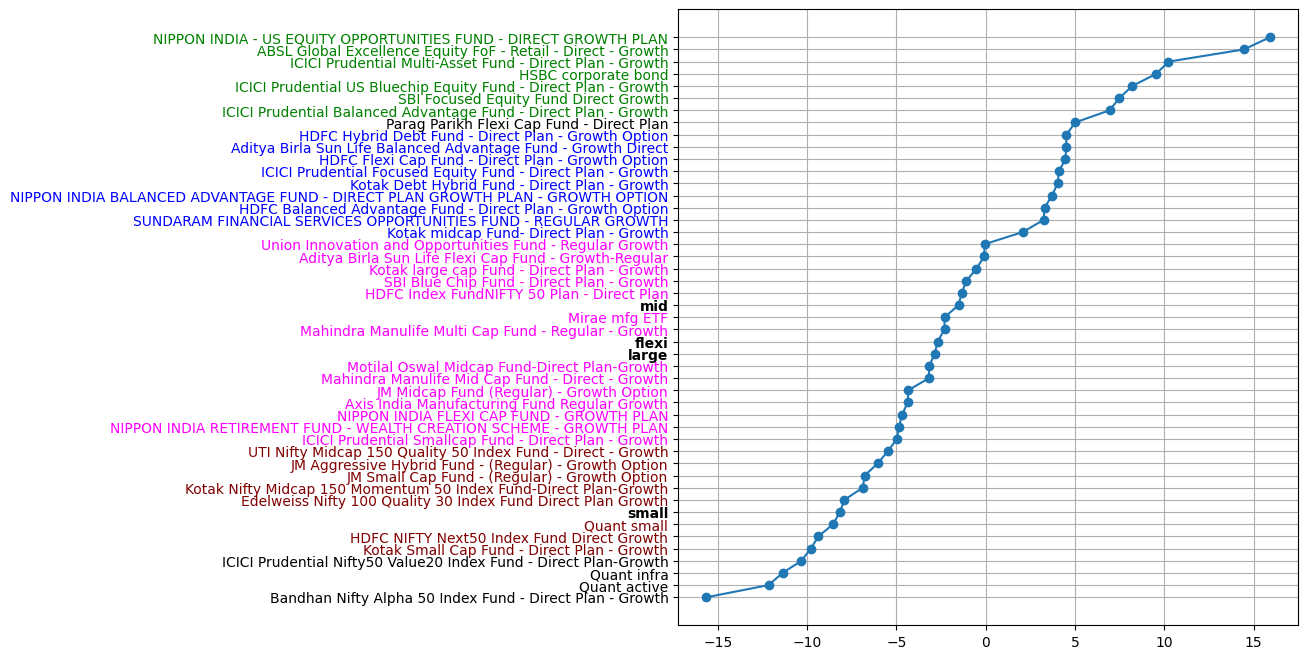

In [10]:

fig = plt.figure(figsize=(8,8))

change_list, mf_names = [], []
for name, vals in mf_fall.items():
    change = (vals[-1] - vals[0])/vals[0]
    change_list.append(round(change*100, 2))
    mf_names.append(name)

mf_names1, change_list = zip(*sorted(zip(mf_names, change_list), key=lambda x: x[1]))

plt.plot(change_list, mf_names1, marker='o')

ax = plt.gca()
for i, label in enumerate(ax.get_yticklabels()):
    if change_list[i] > 5: label.set_color('green')
    elif change_list[i] < 5 and change_list[i] > 0: label.set_color('blue')
    elif change_list[i] < 0 and change_list[i] > -5: label.set_color('magenta')
    elif change_list[i] < -5 and change_list[i] > -10: label.set_color('maroon')
    if label.get_text() in benchmark_idx['name']:
        label.set_fontweight('bold')
        label.set_color('black')
    # if label.get_text().split()[0].lower() in my_mf: label.set_fontweight('bold')



plt.grid(True, which='both')
plt.show()

### 2. Category-wise Percentage Variation from ATH for detailed analysis
- To analyse performance/behaviour of MF over last year

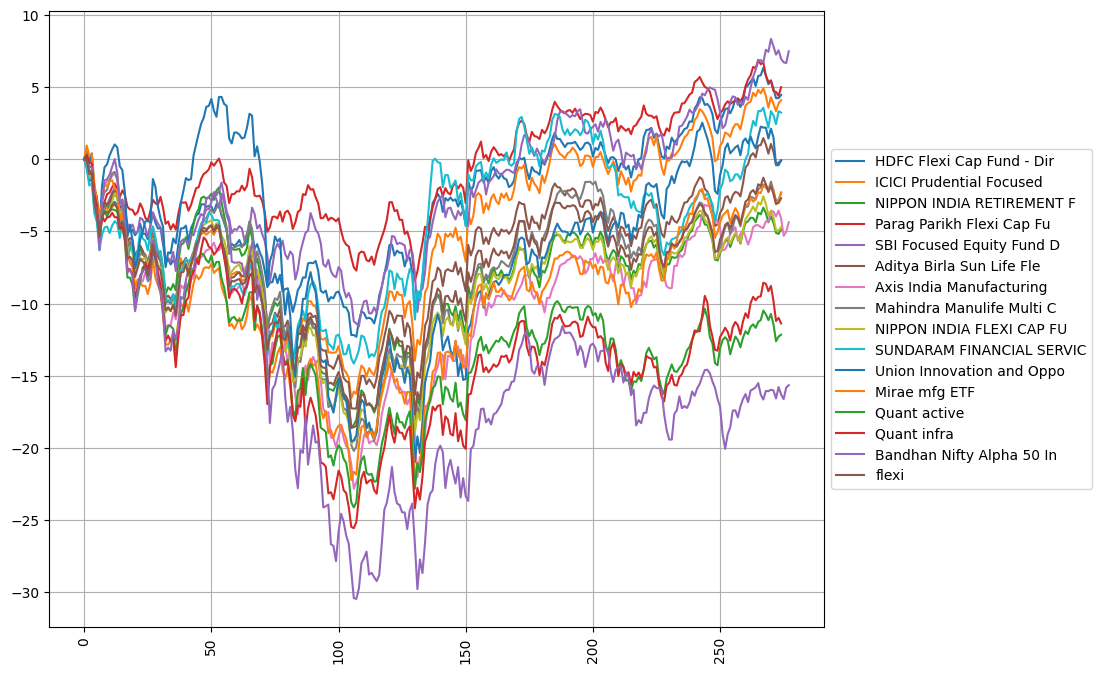

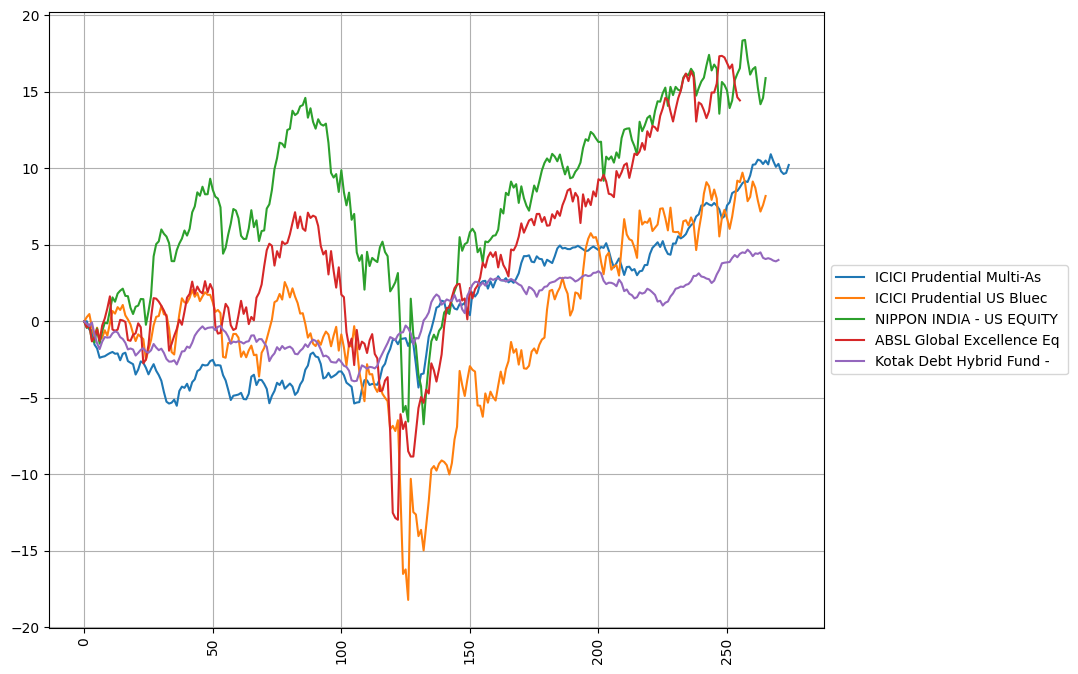

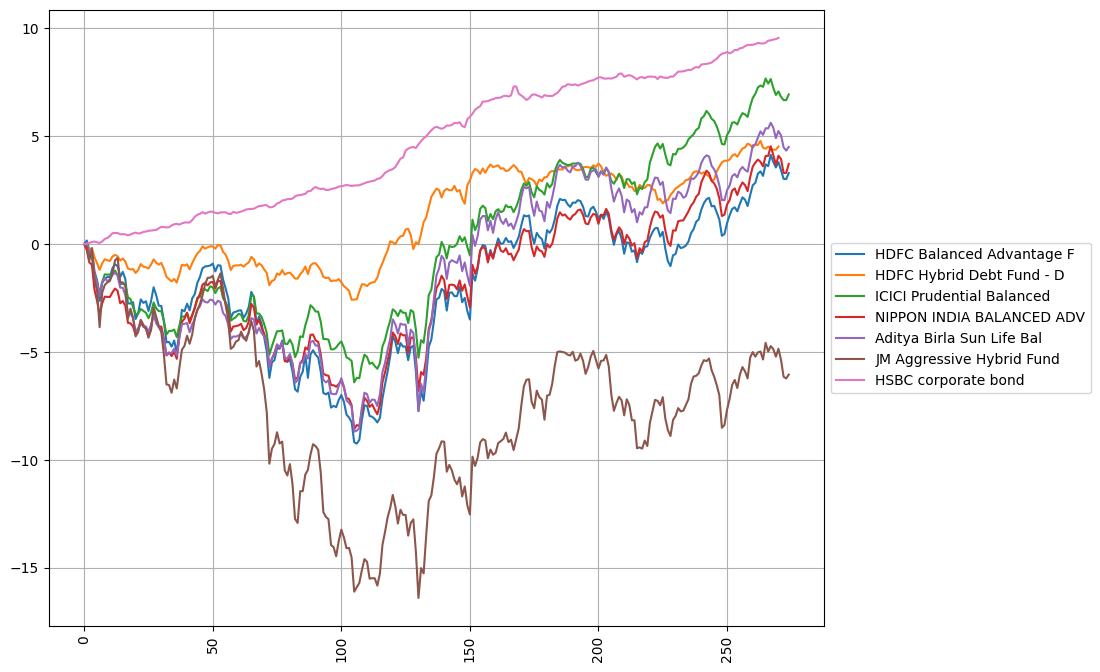

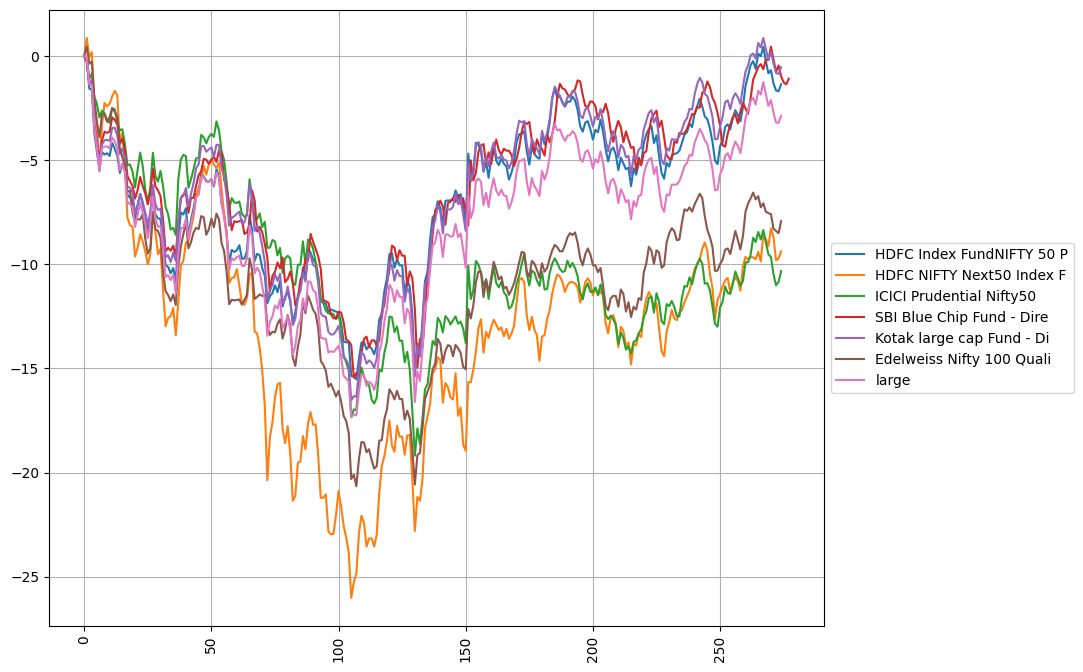

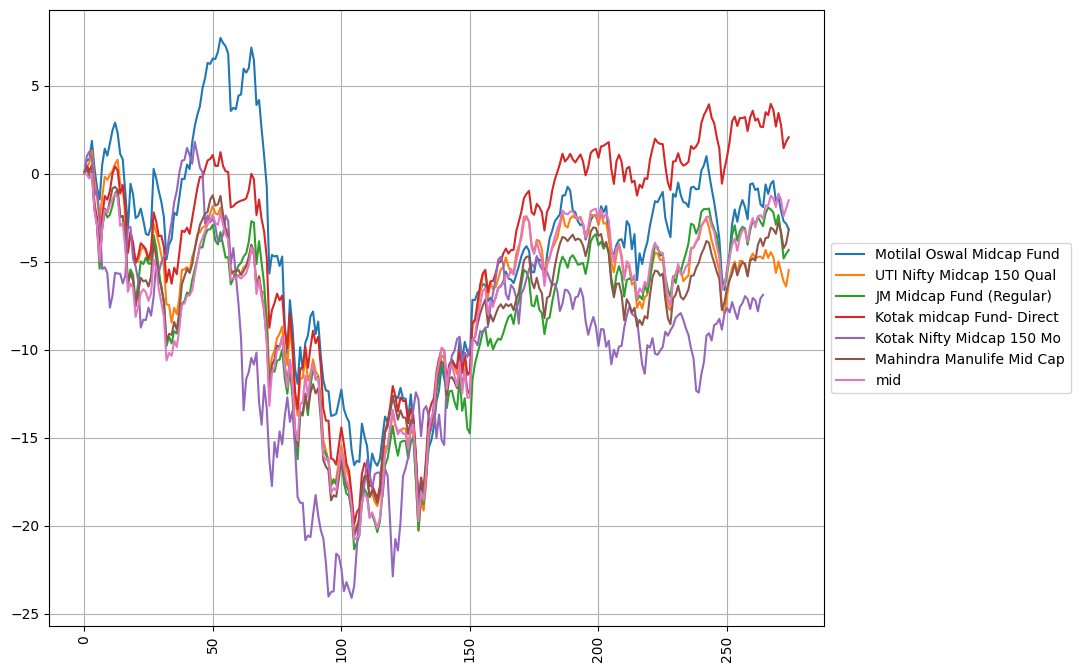

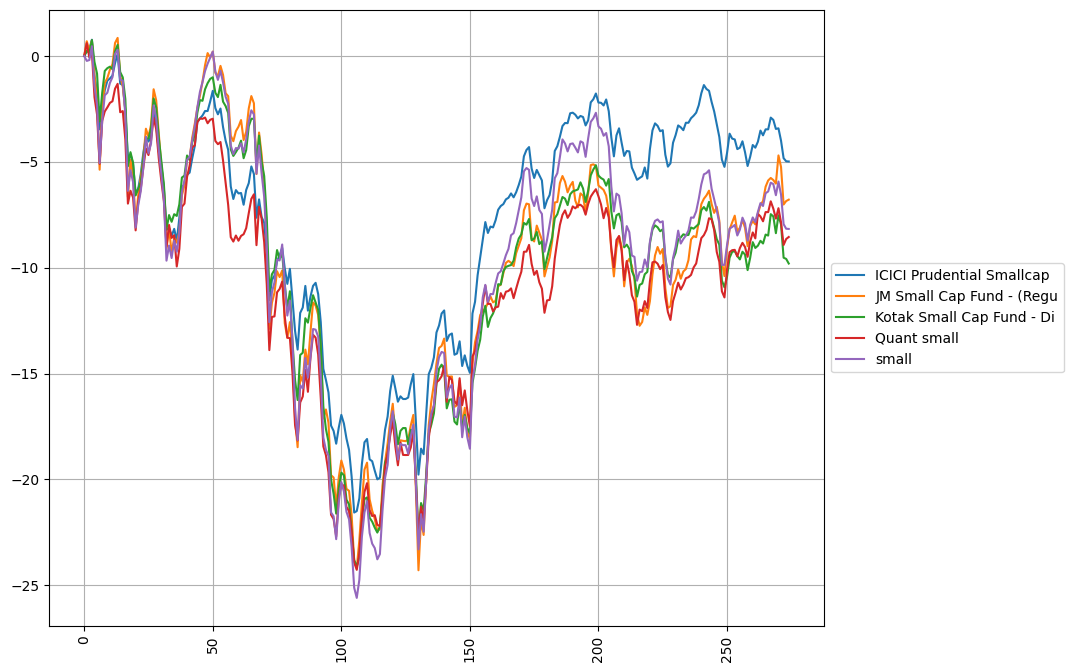

In [11]:

for cat, df in mf_df.groupby('id'):
    fig = plt.figure(figsize=(10,8))

    for idx, row in df.iterrows():
        vals = mf_fall[row['name']]
        pc_var = (vals - vals[0])*100/vals[0]
        plt.plot(pc_var, label=row['name'][:25])
    plt.xticks(rotation=90)
    plt.grid(True, which='both')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()




### 3. Analysis of Ratios -- Important

- Sharpe Ratio: Returns over risk free, weighted by its variance. Higher value is better returns comapred to Risk taken
    - Neagtive sharpe ratio: Underperformance of asset in a given period.
- Beta: Relative volatality with Market.
    - Low value means less fluctuations compared to market and Good for short term durations
- Alpha: Extra return over Market and Risk free return, weighted by Beta
- Info: it measures ability to generate risk-adjusted excess returns above a benchmark, quantifying a fund manager's skill and consistency in outperforming the market.
    - Its fund's return over benchmark return, divided by SD of this excess return.
    - Higher value shows that fund manager is consistently generating higher returns than the benchmark with less risk.
    - Sharpe is with Risk free and Info with benchmark
    
- (There is intentional bug in code. Info Ratio is calculated with Nifty50 for general comparision. Ideally its calculated with category benchmark for that fund (eg. mid, small, flexi)

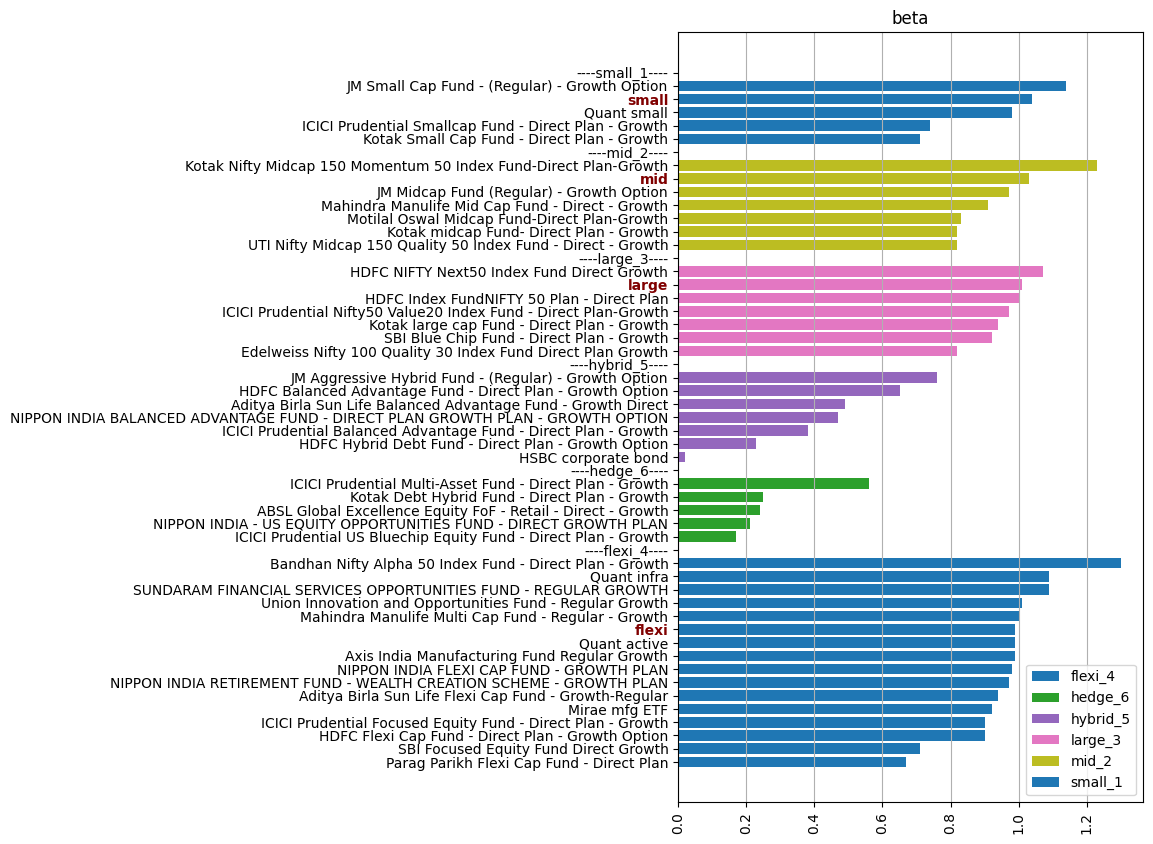

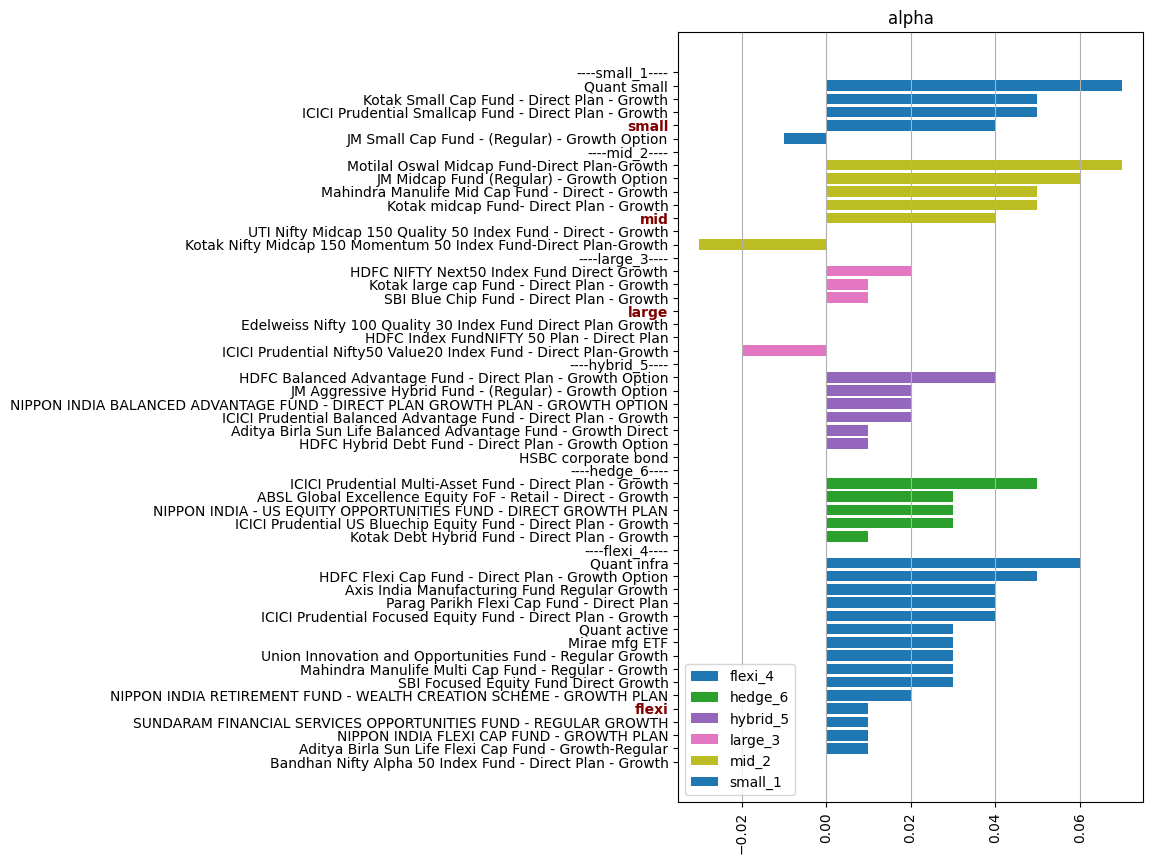

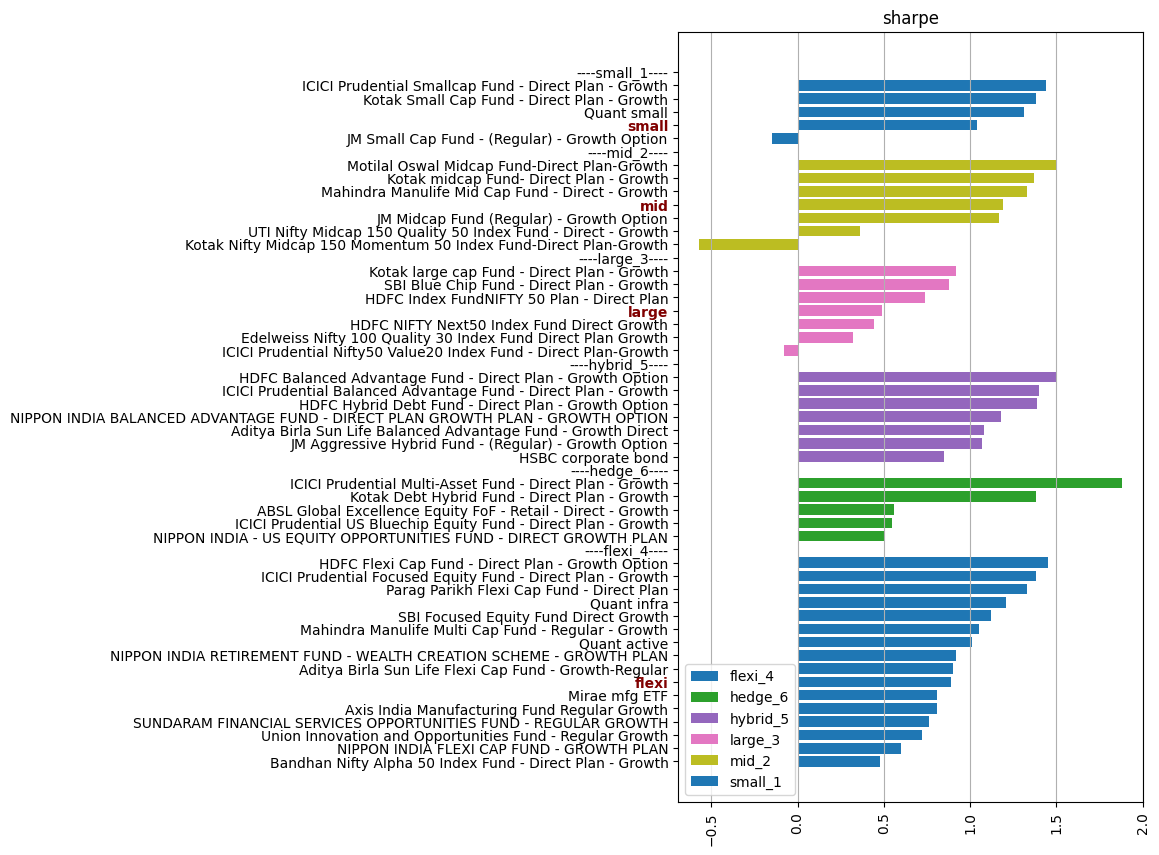

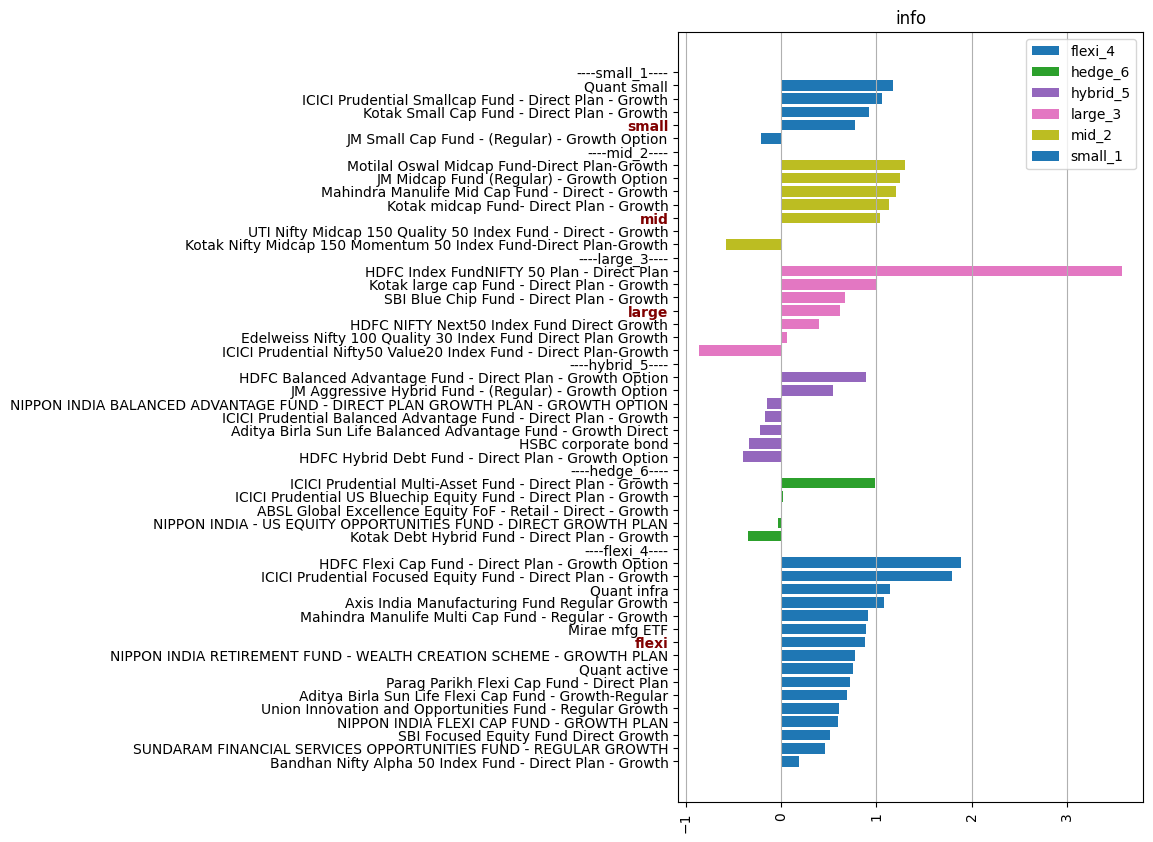

In [13]:

for ratio in ['beta', 'alpha', 'sharpe', 'info']:
    fig = plt.figure(figsize=(6,10))
    for cat, df in mf_df.groupby('id'):
        df = df.sort_values(by=ratio)
        plt.barh(df['name'], df[ratio], label=cat)
        plt.barh('----'+cat+'----', 0, label=None)
    plt.title(ratio)
    plt.xticks(rotation=90)
    plt.grid(True, axis='x')
    plt.legend()

    ax = plt.gca()
    for i, label in enumerate(ax.get_yticklabels()):
        if label.get_text() in benchmark_idx['name']:
            label.set_fontweight('bold')
            label.set_color('maroon')

    plt.show()



### 4. Rolling ratio variations

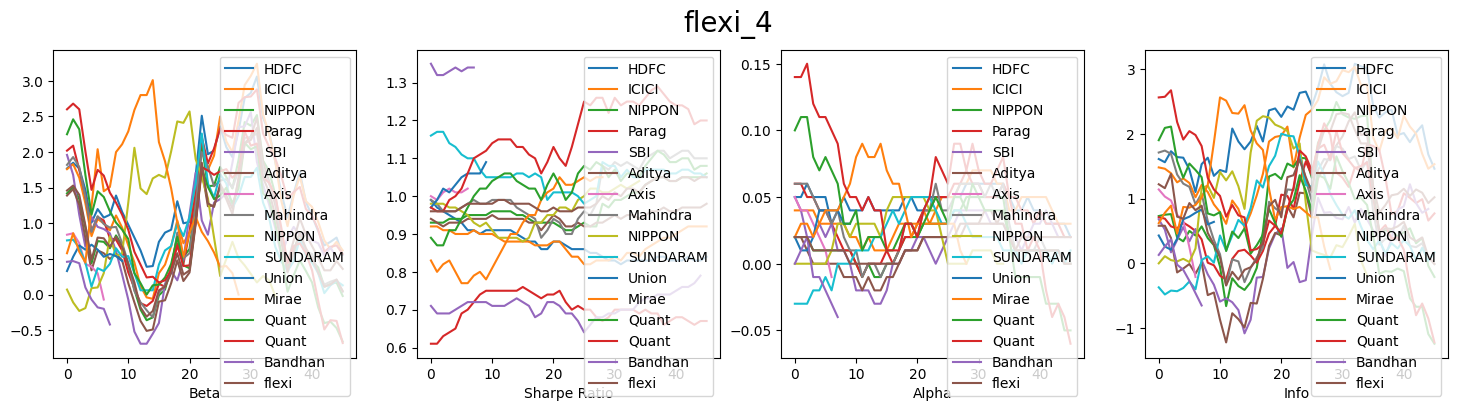

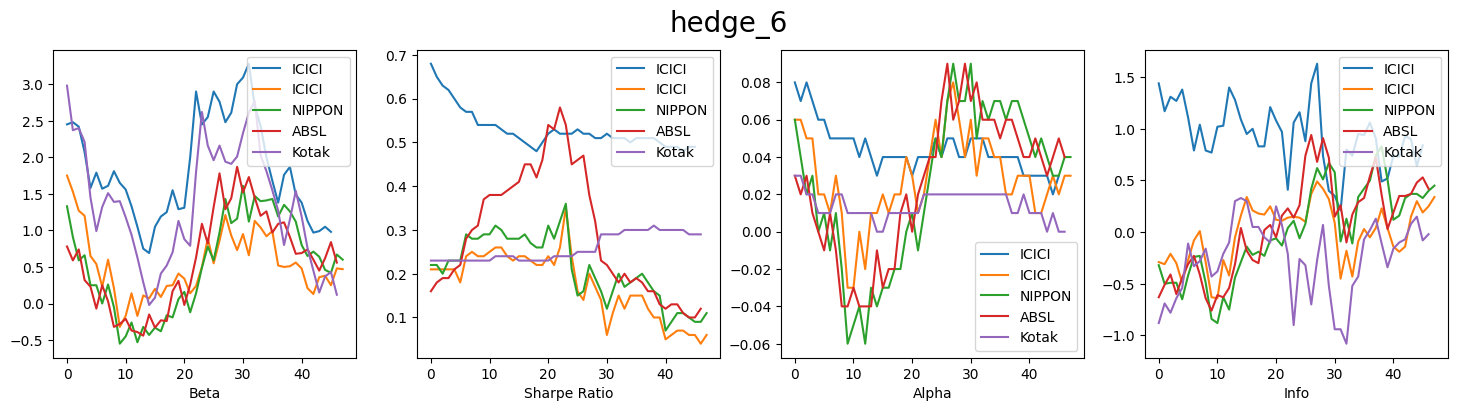

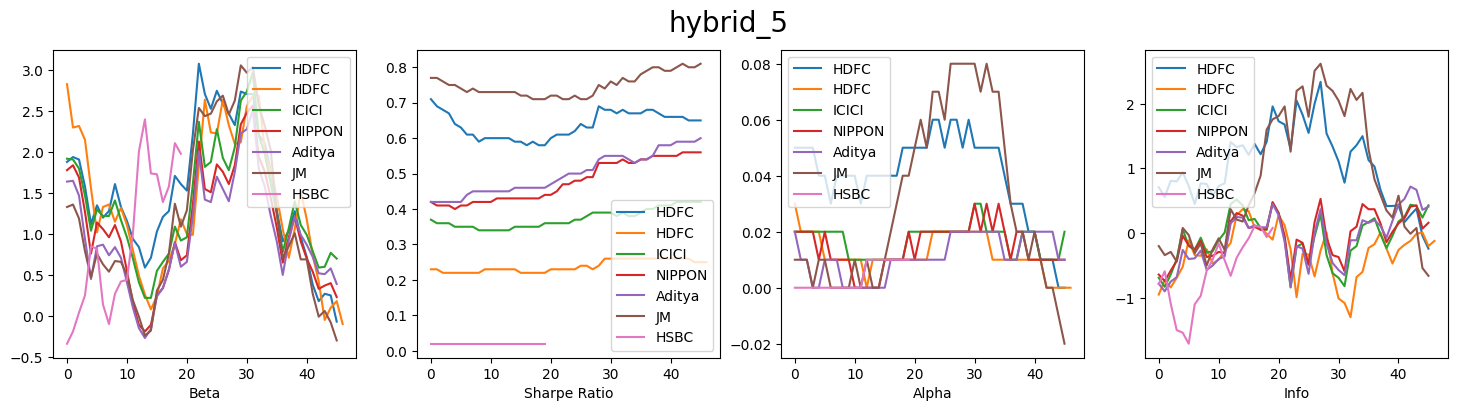

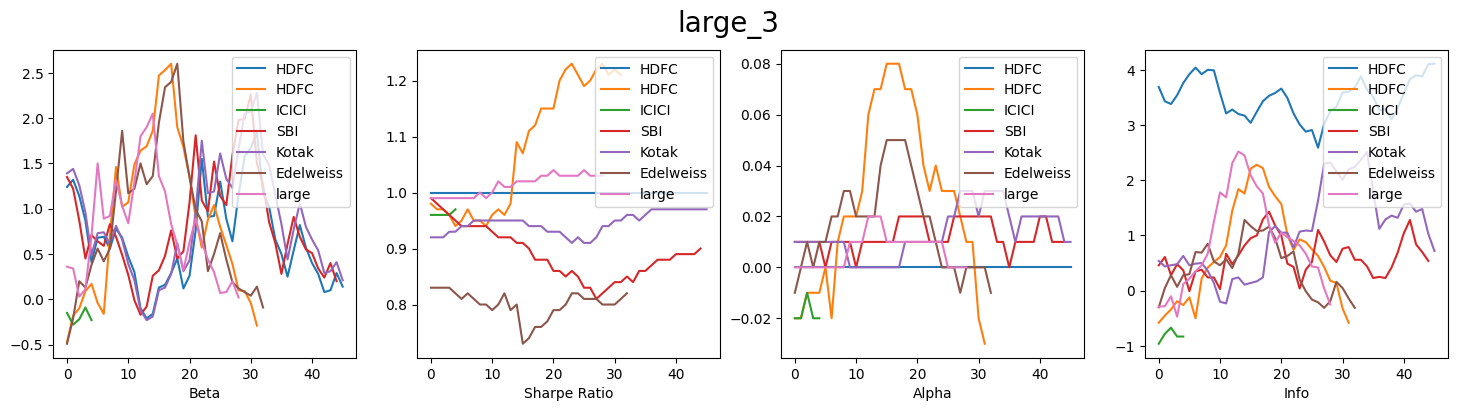

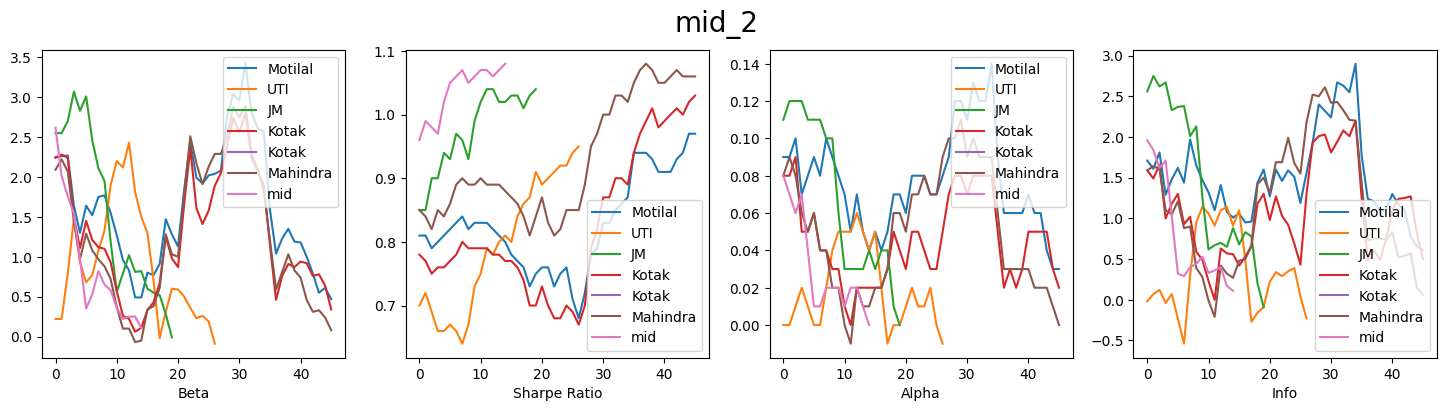

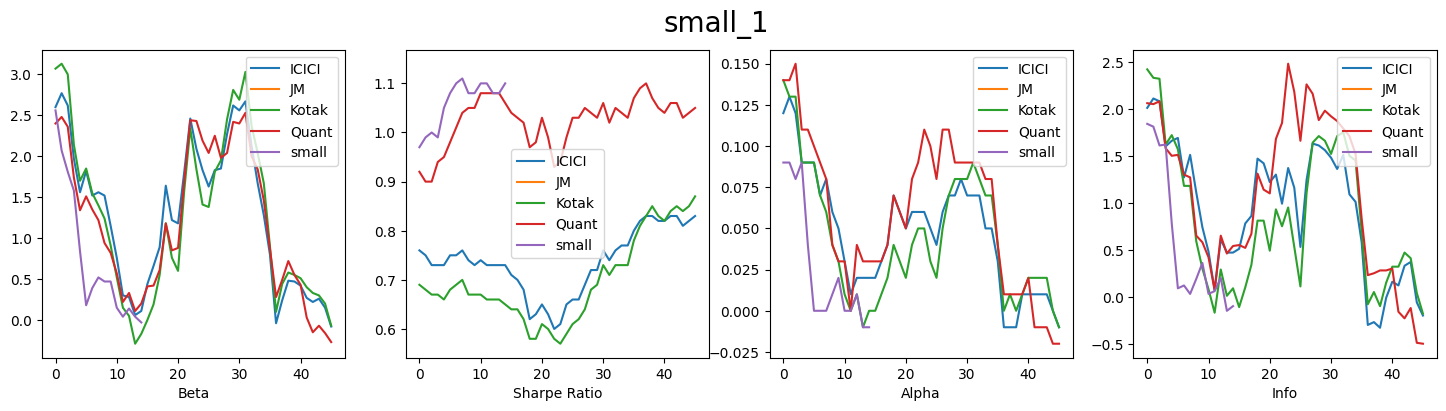

In [15]:
for cat, df in mf_df.groupby('id'):
    fig = plt.figure(figsize=(18,4))
    fig.suptitle(cat, fontsize=20)

    ax = fig.add_subplot(1,4,1)
    for index, row in df.iterrows():
        plt.plot(row['rolling_beta'], label='_'.join(row['name'].split(' ')[:1]))
    plt.xlabel('Beta')
    plt.legend()

    ax = fig.add_subplot(1,4,2)
    for index, row in df.iterrows():
        plt.plot(row['rolling_sharpe'], label='_'.join(row['name'].split(' ')[:1]))
    plt.xlabel('Sharpe Ratio')
    plt.legend()

    ax = fig.add_subplot(1,4,3)
    for index, row in df.iterrows():
        plt.plot(row['rolling_alpha'], label='_'.join(row['name'].split(' ')[:1]))
    plt.xlabel('Alpha')
    plt.legend()

    ax = fig.add_subplot(1,4,4)
    for index, row in df.iterrows():
        plt.plot(row['rolling_info'], label='_'.join(row['name'].split(' ')[:1]))
    plt.xlabel('Info')
    plt.legend()

    plt.show()

### 5. Plotting all ratios together for each fund and sorted
- Can be useful for comparison within each other

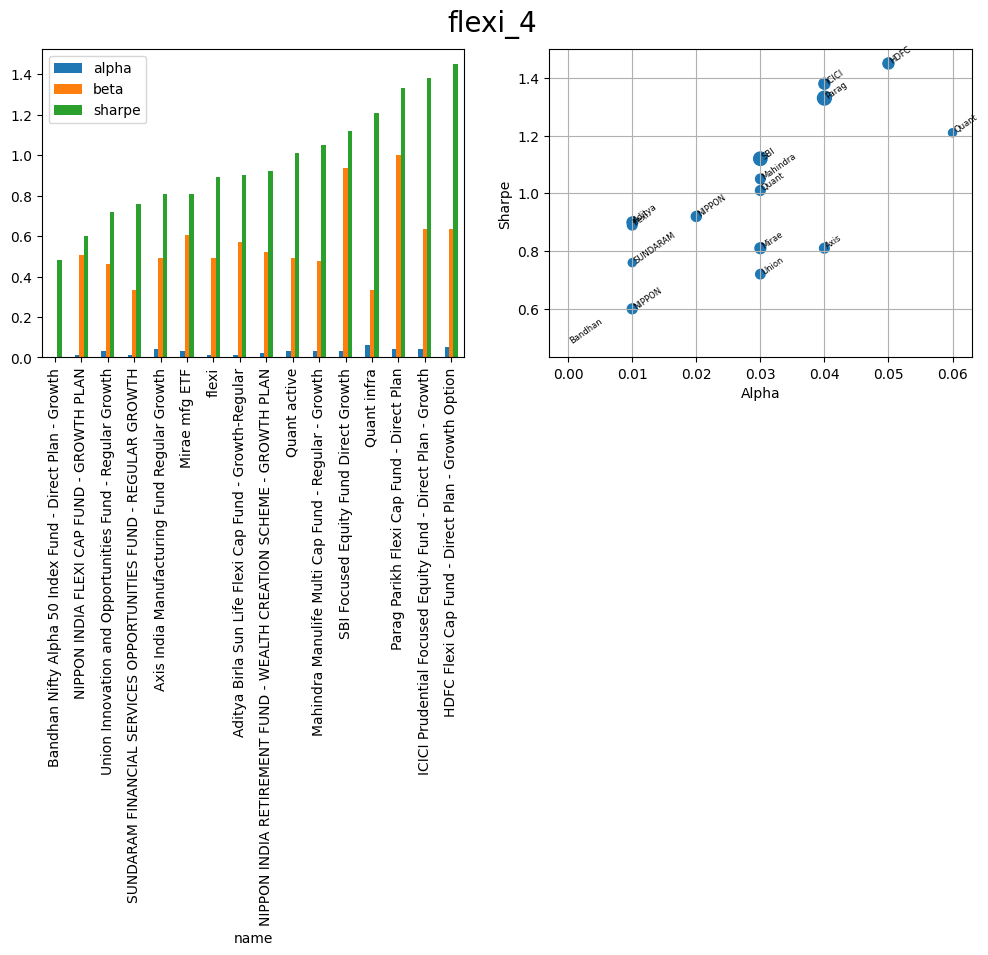

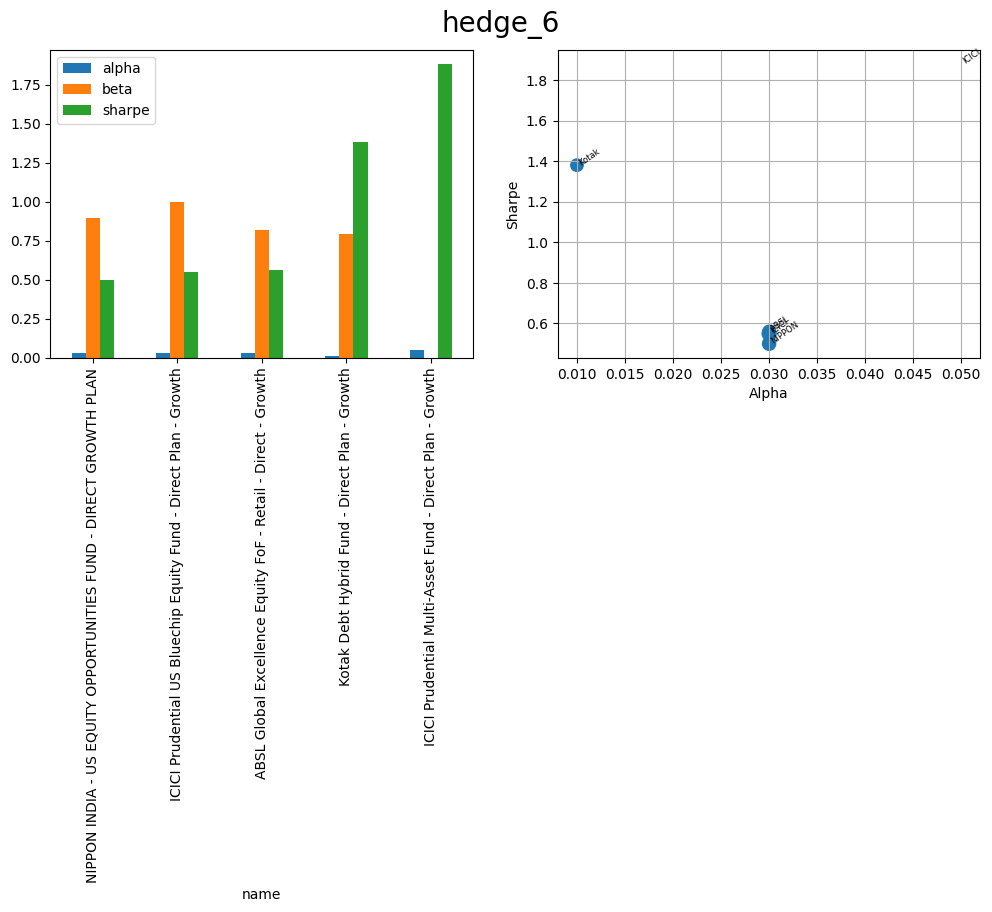

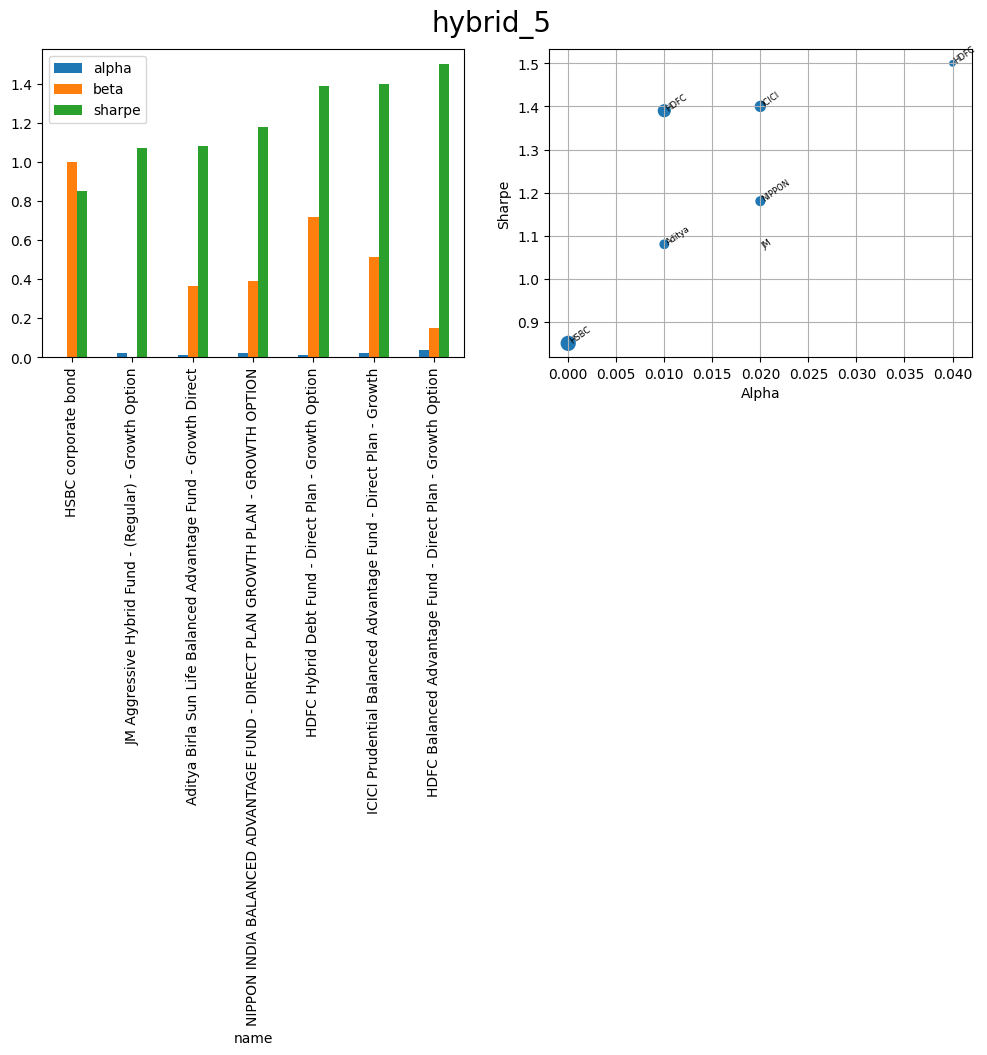

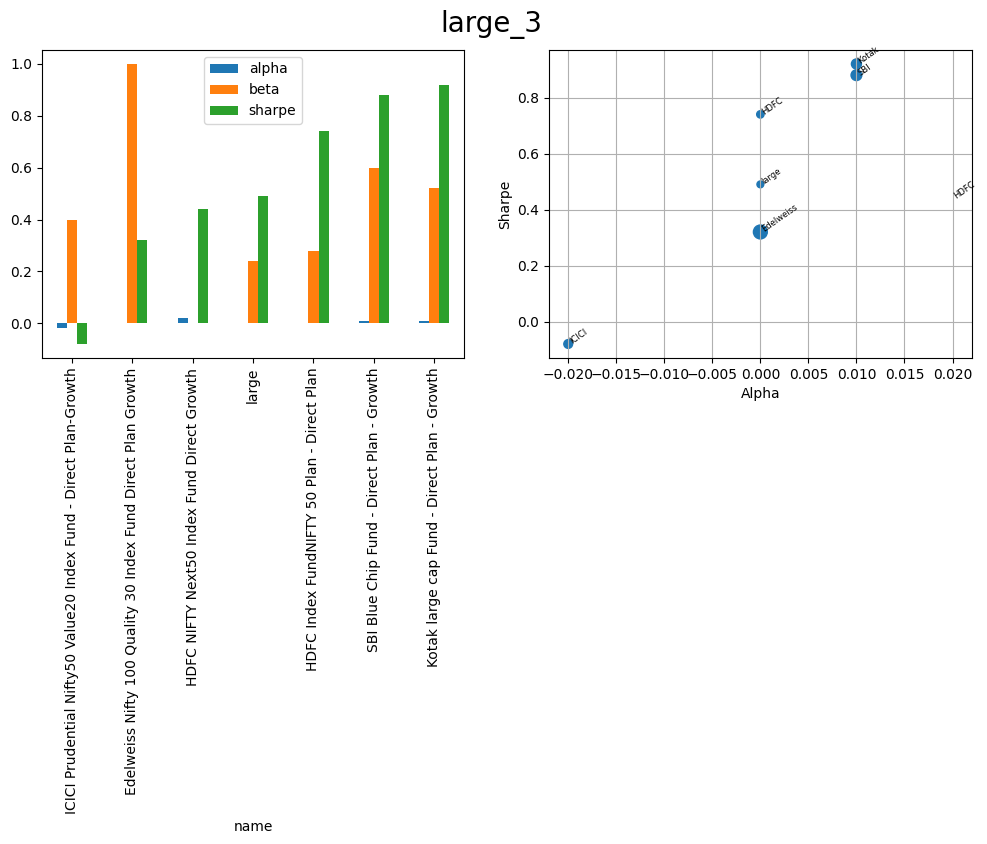

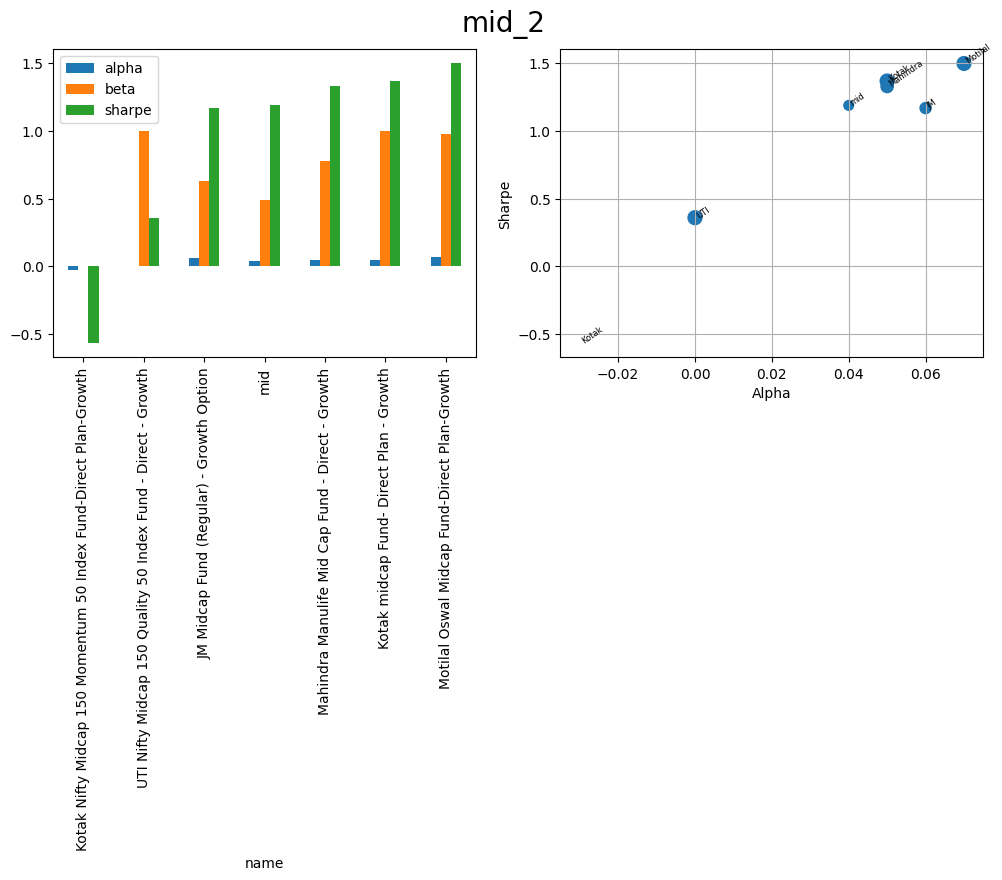

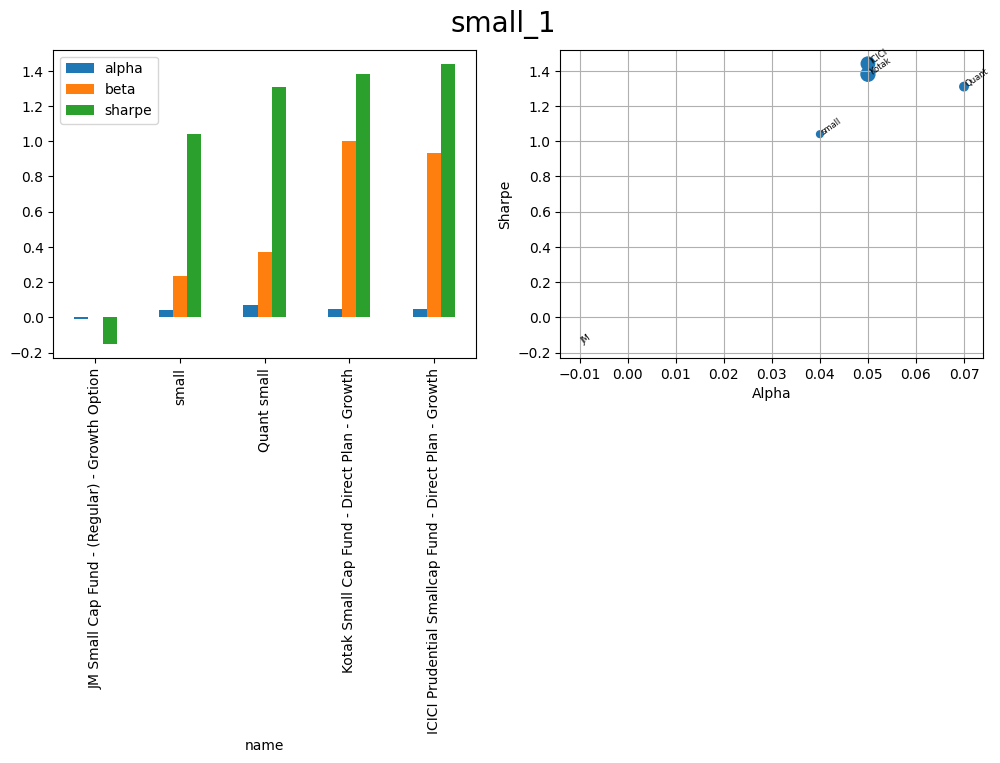

In [19]:
for cat, df in mf_df.groupby('id'):
    fig = plt.figure(figsize=(12,4))
    fig.suptitle(cat, fontsize=20)
    ax = fig.add_subplot(1,2,1)
    df = df[['name','alpha', 'beta', 'sharpe']].copy()
    df['beta'] = 1 - (df['beta'] - df['beta'].min()) / (df['beta'].max() - df['beta'].min())
    df.sort_values(by='sharpe').set_index('name').plot.bar(ax=ax)

    ax = fig.add_subplot(1,2,2)
    plt.scatter(df['alpha'], df['sharpe'], s=df['beta']*100)
    for _, row in df.iterrows():
        plt.annotate(row['name'].split(' ')[0], xy=(row['alpha'],row['sharpe']), fontsize=6, rotation=35)
    plt.xlabel('Alpha')
    plt.ylabel('Sharpe')
    plt.grid(True, which='both')
    plt.show()


## Part 2: Portfolio Analysis

- Below is the example portfolio for ₹20 lakhs
    - 60% in equity (mid, small, flexi), 10% US funds, 15% large, 15% hybrid funds
- Change them as per your funds
- This code is with yfinance, MF codes can be obtained from yahoo finance

In [28]:
mf_names = ['Quant active fund direct growth', 'Kotak Small cap', 'Parag Parikh Flexi Cap Fund', 'MM mid cap unnati yojna', 'Kotak Emerging Equity', 'MAKEINDIA', 'Quant Infrastructure',
            'Nippon india - US equity oppo', 'ICICI Pru US Bluechip', 'HDFC Index Fund Nifty 50', 'HDFC NIFTY Next 50 Index Fund', 'Canera robeco bluechip', 'Absl balance advantage', 'HDFC debt hybrid']
mf_codes = ['0P0000XW4E.BO', '0P0000XV6I.BO', '0P0000YWL1.BO', '0P0001CEW2.BO', '0P0000XV5R.BO', 'MAKEINDIA.NS', '0P0000XW4O.BO', '0P00016GW1.BO', '0P0000XUZC.BO', '0P0000XW7T.BO', '0P0001NK4B.BO',
            '0P0000XW0O.BO', '0P0000XV24.BO', '0P0000XW8G.BO']
units = [276.59, 1402.33, 4028.26, 15593.96, 1392.83, 900.00, 3069.79, 3612.31, 2329.89, 617.98, 12461.10, 3373.96, 1890.72, 2405.14]
costs = [120000, 250000, 205000, 280000, 120000, 75000, 75000, 90000, 110000, 100000, 120000, 150000, 150000, 150000]

mf_mapping = {code:name for code, name in zip(mf_codes, mf_names)}

period1 = '1y'

mf_nav = {}
max_len = 0
latest = []


for code in mf_codes:
    stock = yf.Ticker(code)
    hist = stock.history(period1=period1)
    mf_nav[code] = hist['Close'].values
    latest.append(hist.index.values[-1])
    if len(hist) > max_len:
        max_len = len(hist)
        dates = hist.index.values

current_val = [vals[-1]*x for vals, x in zip(mf_nav.values(), units)]
current_nav = [vals[-1] for vals in mf_nav.values()]
print('\nCurrent Value = ', round(sum(current_val)), '\n')



## Not Accurate, rough estimate of CAGR from given date
years = (pd.to_datetime('today') - pd.to_datetime('12 Aug 2022')).total_seconds() / (24 * 60 * 60) / 365
cagr = (sum(current_val) / 2000000) ** (1 / years) - 1
print(f"The CAGR is {cagr:.2%}")




Current Value =  3458795 

The CAGR is 18.33%


In [29]:
## Summary

mf_df = pd.DataFrame({'mf_names': mf_names, 'mf_codes': mf_codes, 'units':units, 'costs':costs,
                      'NAV':current_nav, 'value':current_val,
                      'date':latest,
                      })
mf_df['profit'] = mf_df['value'] - mf_df['costs']
mf_df.round(2)

mf_names       mf_codes     units   costs     NAV  \
0   Quant active fund direct growth  0P0000XW4E.BO    276.59  120000  681.68   
1                   Kotak Small cap  0P0000XV6I.BO   1402.33  250000  302.36   
2       Parag Parikh Flexi Cap Fund  0P0000YWL1.BO   4028.26  205000   93.54   
3           MM mid cap unnati yojna  0P0001CEW2.BO  15593.96  280000   38.33   
4             Kotak Emerging Equity  0P0000XV5R.BO   1392.83  120000  159.83   
5                         MAKEINDIA   MAKEINDIA.NS    900.00   75000  155.46   
6              Quant Infrastructure  0P0000XW4O.BO   3069.79   75000   42.08   
7     Nippon india - US equity oppo  0P00016GW1.BO   3612.31   90000   40.88   
8             ICICI Pru US Bluechip  0P0000XUZC.BO   2329.89  110000   76.12   
9          HDFC Index Fund Nifty 50  0P0000XW7T.BO    617.98  100000  248.57   
10    HDFC NIFTY Next 50 Index Fund  0P0001NK4B.BO  12461.10  120000   16.41   
11           Canera robeco bluechip  0P0000XW0O.BO   3373.96  150000   74.45   
12           Absl balance advantage  0P0000XV24.BO   1890.72  150000  123.10   
13                 HDFC debt hybrid  0P0000XW8G.BO   2405.14  150000   88.57   

        value                date     profit  
0   188545.26 2025-11-09 18:30:00   68545.26  
1   424015.50 2025-11-09 18:30:00  174015.50  
2   376814.72 2025-11-06 18:30:00  171814.72  
3   597674.40 2025-11-09 18:30:00  317674.40  
4   222610.45 2025-11-09 18:30:00  102610.45  
5   139914.01 2025-11-10 18:30:00   64914.01  
6   129162.95 2025-11-09 18:30:00   54162.95  
7   147663.64 2025-11-06 18:30:00   57663.64  
8   177351.23 2025-11-06 23:00:00   67351.23  
9   153610.98 2025-11-09 18:30:00   53610.98  
10  204457.99 2025-11-09 18:30:00   84457.99  
11  251191.31 2025-11-09 18:30:00  101191.31  
12  232747.63 2025-11-09 23:00:00   82747.63  
13  213034.55 2025-11-09 18:30:00   63034.55

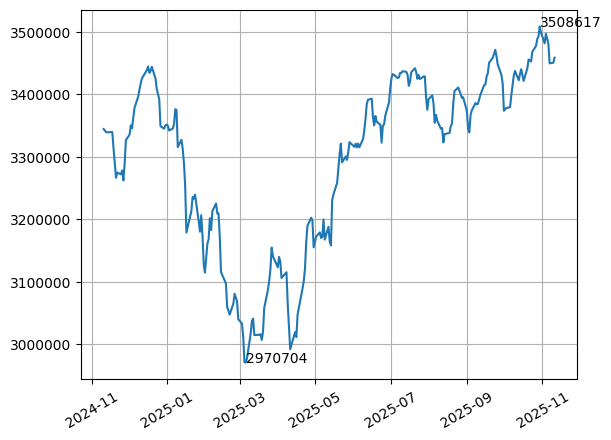

In [30]:
## Variation of Portfolio over given period with Min and Max values

total = np.zeros(max_len,)

fig, ax = plt.subplots()
for i, vals in enumerate(mf_nav.values()):
    prices = np.concatenate([[vals[0]]*(max_len-len(vals)), vals])*units[i]
    # ax.plot(prices, label=mf_names[i])
    total += prices

ax.plot(dates, total, label='Total')
ax.ticklabel_format(useOffset=False, style='plain', axis='y')

max_val, max_idx = np.max(total), np.argmax(total)
min_val, min_idx = np.min(total), np.argmin(total)
ax.annotate(f'{round(max_val)}', xy=(dates[max_idx], max_val))
ax.annotate(f'{round(min_val)}', xy=(dates[min_idx], min_val))
plt.grid(True, which='both')
plt.xticks(rotation=30)
plt.show()

In [31]:
## Current month's return


daily_df = pd.DataFrame({'date':dates, 'value':total})
daily_df['month'] = daily_df['date'].dt.month
daily_df['change'] = daily_df['month'] - daily_df['month'].shift(-1)

idx = daily_df['change'].where(daily_df['change']!=0).dropna().index[-1]

change = (total[-1] - total[idx])/total[idx]
print('Change : ', round(change*100, 2))

daily_df.iloc[idx:, :2].round()

Change :  -1.15


date      value
241 2025-10-30 18:30:00  3498908.0
242 2025-11-02 18:30:00  3481794.0
243 2025-11-03 18:30:00  3497070.0
244 2025-11-05 18:30:00  3481581.0
245 2025-11-06 18:30:00  3449740.0
246 2025-11-09 18:30:00  3450682.0
247 2025-11-10 18:30:00  3458795.0